# Cov19: Base-final evaluation: troponin = 'all'

In [24]:
import os
import ast
import sys
import shutil
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pformat, pprint
from helpers import _build_summary_data, plot_missing_values_per_group, ModelEvaluation
from misc.df_plotter.mv_plotter import MissingValuePlotter
from misc.df_plotter.box_plotter import BoxPlotter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import estimator_html_repr
from IPython.core.display import display, HTML
from IPython.display import Markdown as md
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


In [25]:
# REMARK: change parameters of this cell and the script/notebook will run for either longitudinal
# or base evaluation, but markdown text will mostly not be influenced. So markdown cells have
# to be adjusted by hand in every script!

study_type = 'base' # 'base'
target = 'group'  # target feature as string
target_mapping = {'positive': 1, 'negative': 0}
working_file = "working_file_base_2021-03-22"  # name of working file (without ending) as string
working_dir = "data/simulation_knn_imputation_troponin_all"
chosen_model = None # 'AdaBoostClassifier'  # 'KNeighborsClassifier' # 'LogisticRegression'  # if None best model (mean test accuracy) is taken
re_calculate = False  # time consuming calculations will not be done again if re_calculate = False and file exists in folder
no_features = 15 # number of features for SFS (Feature Importance)
test_size = 0.25  # chosen size of analyzed test set

This notebook shows the methodical way of analyzing the base data of <b>COV19</b> (positive vs. negative): troponin = 'all'

1. run <b>'train_test_split_analysis.py'</b> with repeated randomized train-test-splits with different split-sizes -> <b>evaluate the optimal fraction to split into train- and test data </b>.

2. selecting 'optimal' train-test-split-size-fraction and <b>getting best model from all supported model types </b> (LogisticRegression, KNeighborsClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,
GradientBoostingClassifier, SVC). <b>Best model = reaching best mean test-accuracy-score (on unseen data)</b>

3. With this model and its best hyperparameters <b>retrain all data</b> and analyze results with its <b>FeatureImportance</b>

## 1. train_test_split_analysis

In this section the behaviour between train-data-size and test-data-size is analyzed. Goal ist to get an optimal fraction the reach stable and valid results. An optimal fraction is reached if variance in results on train- and test-data is relativly low. Normally many train-data and few test-data leeds to a low variance in train but a high variance in test-results and visa verse. Somewhere between should be an optimum. This fraction is taken for further analysis!

In [26]:
# os.chdir(Path(os.getcwd(), working_dir))

if study_type == 'long':
    data = pd.read_pickle(f"{working_file}.pkl")
else:
    data = pd.read_pickle(f"{working_file}_adjusted.pkl")

In [27]:
fig = MissingValuePlotter(df=data).get_plot()
fig.write_html(f"MissingValuePlotter.html")
fig.show()

In [28]:
data_summary = _build_summary_data(data, target)
fig = plot_missing_values_per_group(data_summary, target)
fig.write_html(f"mv_per_group_before_transformation.html")
fig.show()

From train-test-split-analysis the next 2 plots have been generated:
- data-file have been analyzed with 15 different randomized splits into train- and testdata (random_states: 1, 2, 3, 25, 26, 10, 11, 12, 13, 14, 33, 34, 35, 36, 37) and different test-sizes (<b>test_sizes: 0.1, 0.15, 0.2, 0.25, 0.3, 0.35</b>)
- the results of this simulation has been plotted per algorithm (<b>LogisticRegression, KNeighborsClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, SVC</b>)

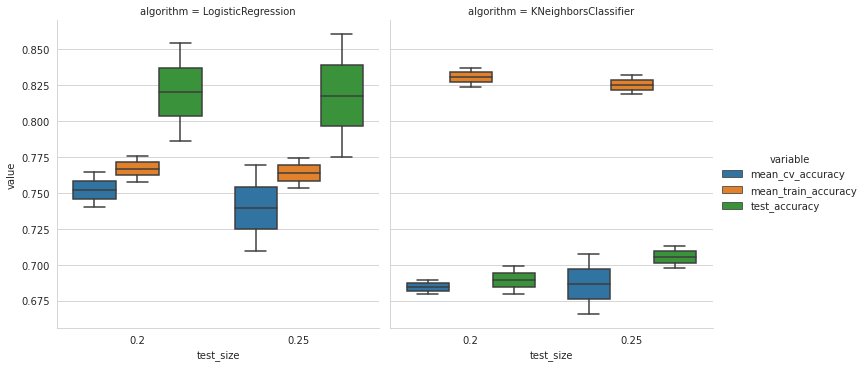

In [29]:
try:
    sim_data = pd.read_csv(f"train_test_split_simulation.csv", index_col=0)
except FileNotFoundError:
    raise Exception(f"File not found!")

data_mod = sim_data.melt(id_vars=['algorithm', 'test_size', 'random_state'],
                     value_vars=['mean_cv_accuracy', 'mean_train_accuracy', 'test_accuracy'])
# build plot
sns.set_style("whitegrid")
sns.catplot(data=data_mod, x='test_size', y='value', col='algorithm', hue='variable', kind='box', col_wrap=2)
plt.savefig(f"train_test_analysis.png")

These plots show the estimated behaviour. With low test-sizes (0.1) the variance in test_accuracy is high. This variance is getting lower if the test_size is increased. From visual sight an optimum could be around a <b>test-size of 0.25</b>. At this point variance of train- and test-accuracy seems to be relatively low.

It's also visible that the GradientBoostingClassifier seems to overfit data as seen in the huge gap between mean_train_accuracy and test accuracy.

## 2. getting best model from all suported model types

In a second step the best model of all supported models and hyperparameters is selected. The best model is this one reaching the best mean test-accuracy-score (accuracy score on unseen data).
After catching the <b>optimal train-test-split-size of 0.25</b> only these results will be considered on next steps of this analysis!

Output of former analysis have been two .csv file with all best models (hyperparameters) per algorithm and train-test-split/random_state.

In [30]:
pd.DataFrame(sim_data)

,algorithm,simulation,best_params,mean_cv_accuracy,cv_std,mean_train_accuracy,train_std,test_accuracy,test_size,random_state
0,LogisticRegression,0,"{'estimator__C': 1, 'estimator__penalty': 'l2'...",0.740024,0.081015,0.757874,0.013996,0.854369,0.20,1
1,KNeighborsClassifier,0,"{'estimator__n_neighbors': 3, 'prep__num_pipel...",0.679547,0.040015,0.824007,0.016309,0.699029,0.20,1
2,LogisticRegression,1,"{'estimator__C': 1, 'estimator__penalty': 'l2'...",0.709957,0.032279,0.753238,0.011646,0.860465,0.25,1
3,KNeighborsClassifier,1,"{'estimator__n_neighbors': 3, 'prep__num_pipel...",0.665801,0.019048,0.818661,0.007750,0.713178,0.25,1
4,LogisticRegression,2,"{'estimator__C': 1, 'estimator__penalty': 'l2'...",0.764678,0.038983,0.776093,0.010722,0.786408,0.20,2
5,KNeighborsClassifier,2,"{'estimator__n_neighbors': 3, 'prep__num_pipel...",0.689509,0.035514,0.837382,0.010893,0.679612,0.20,2
6,LogisticRegression,3,"{'estimator__C': 1, 'estimator__penalty': 'l2'...",0.769364,0.019757,0.774604,0.011290,0.775194,0.25,2
7,KNeighborsClassifier,3,"{'estimator__n_neighbors': 3, 'prep__num_pipel...",0.707293,0.047332,0.832245,0.010064,0.697674,0.25,2


From this tables only <b>test_size=0.25</b> will be taken for further analysis:
The best model overall is the model with the best mean-test-accuracy (on test-size=0.25). It's best hyperparameters are detected in a majority-vote

In [31]:
size_test_data = 0.25

def build_best_param_from_str(params):
    best_param = {}
    param_str = params.index[0]
    param_str = param_str[1:-1]
    param_str_list = str.split(param_str, ',')
    for item in param_str_list:
        item_list = str.split(item, ':')
        for ch in ['"', '\\', "'", " "]:
            item_list[0] = item_list[0].replace(ch, '')
        best_param.update({item_list[0]: eval(item_list[1])})
    return best_param

for i, sd in enumerate([sim_data]):
    data_red = sd[sd['test_size'] == size_test_data]  # optimum between variance in train- and test-score (watch plot)
    best_algorithms = data_red.groupby("algorithm").mean().sort_values(by=['test_accuracy', 'mean_cv_accuracy'], ascending=False)

    if chosen_model is None:
        best_algorithm = best_algorithms.index[0]
        idx = 0
    else:
        best_algorithm = chosen_model
        idx = best_algorithms.index.get_loc(chosen_model)

    best_params = data_red[data_red['algorithm'] == best_algorithm].groupby('best_params').count().sort_values(by="algorithm", ascending=False)
    # best_param = ast.literal_eval(best_params.index[idx])
    best_param = build_best_param_from_str(best_params)

    # performances of best algorithm
    stats = data_red.loc[:, ['mean_cv_accuracy', 'mean_train_accuracy', 'test_accuracy']][
        data_red['algorithm'] == best_algorithm].agg(['mean', 'std'])

    results = {best_algorithm: best_param, 'statistics': stats}
    joblib.dump(results, f"best_model.joblib")
    print(f"{best_algorithm}\n")
    print(f"{best_param}\n")
    print(f"{stats}")

LogisticRegression

{'estimator__C': 1, 'estimator__penalty': 'l2', 'prep__num_pipeline__imputer__n_neighbors': 3}

      mean_cv_accuracy  mean_train_accuracy  test_accuracy
mean          0.739660             0.763921       0.817829
std           0.042007             0.015108       0.060296


## 3. Model evaluation and Feature Importance

In former chapters no word about the model pipelines and it's tuning parameters have been lost. These will be shown in this section. Will will analyze data and it's predictions with best evaluated model in section 2.

### EDA

In [32]:
if study_type == 'long':
    data = pd.read_pickle(f"{working_file}.pkl")
else:
    data = pd.read_pickle(f"{working_file}_adjusted.pkl")
data.head(5)

,group,alt_,antibody-synth-lymph_,aptt_,ast_,ck_mb_,creatinine_,crp_,hgb_,mpv_,...,pt_,reactive-lympho_,troponin_,wbc_,quot_neu_lymphocytes_,quot_eos_lymphocytes_,quot_mon_lymphocytes_,quot_plt_lymphocytes_,quot_baso_lymphocytes_,quot_plt_neu_
id,,,,,,,,,,,,,,,,,,,,,
SC2_Pos1,positive,11.0,0.00,78.5,23.0,NaN,125.1,0.14,13.6,11.1,...,18.1,0.10,0.054,12.76,10.882353,0.088235,0.470588,202.941176,0.039216,18.648649
SC2_Pos10,positive,12.0,0.00,31.3,13.0,0.9,93.5,0.90,15.0,11.6,...,15.3,0.02,0.005,6.63,5.974359,0.012821,1.448718,285.897436,0.038462,47.854077
SC2_Pos100,positive,33.0,0.04,24.6,87.0,9.7,54.1,10.35,13.7,10.2,...,12.3,0.09,1.475,6.79,6.091954,0.000000,0.678161,180.459770,0.011494,29.622642
SC2_Pos101,positive,11.0,0.00,31.8,16.0,0.3,109.8,8.55,13.8,10.5,...,13.9,0.01,0.026,9.06,5.840336,0.000000,0.739496,164.705882,0.016807,28.201439
SC2_Pos102,positive,9.0,0.00,27.0,15.0,1.6,94.2,11.75,13.4,11.1,...,15.5,0.07,0.041,8.07,4.268116,0.014493,0.528986,149.275362,0.014493,34.974533


In [33]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
alt_,384.0,53.867188,189.970853,5.000000,14.000000,24.500000,41.000000,2864.000000
antibody-synth-lymph_,477.0,0.010042,0.029270,0.000000,0.000000,0.000000,0.000000,0.240000
aptt_,458.0,32.975983,13.269349,16.600000,27.100000,30.500000,35.075000,222.600000
ast_,378.0,70.383598,227.797081,7.000000,21.000000,30.000000,55.000000,3239.000000
ck_mb_,426.0,4.141080,27.491986,0.300000,0.700000,1.300000,2.900000,557.400000
creatinine_,504.0,145.095040,190.597133,15.300000,71.300000,90.300000,130.925000,1806.100000
crp_,507.0,8.361105,9.016606,0.050000,1.000000,5.000000,13.480000,41.900000
hgb_,510.0,12.757196,2.448105,0.070000,11.300000,13.000000,14.500000,20.300000
mpv_,501.0,10.716168,1.064649,8.500000,9.900000,10.500000,11.400000,14.200000
neutrophil-granules_,504.0,154.725595,5.226705,132.600000,151.500000,154.850000,158.325000,186.500000


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 515 entries, SC2_Pos1 to SC2_Neg314
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   group                   515 non-null    category
 1   alt_                    384 non-null    float64 
 2   antibody-synth-lymph_   477 non-null    float64 
 3   aptt_                   458 non-null    float64 
 4   ast_                    378 non-null    float64 
 5   ck_mb_                  426 non-null    float64 
 6   creatinine_             504 non-null    float64 
 7   crp_                    507 non-null    float64 
 8   hgb_                    510 non-null    float64 
 9   mpv_                    501 non-null    float64 
 10  neutrophil-granules_    504 non-null    float64 
 11  neutrophil-reactivity_  504 non-null    float64 
 12  pct_                    390 non-null    float64 
 13  pdw_                    496 non-null    float64 
 14  pt_              

In [20]:
if study_type == 'base':
    if not os.path.isfile('pairplot.png'):
        plt.figure(figsize=(15,8))
        fig = sns.pairplot(data=data, hue='group', plot_kws={'alpha':0.2})
        fig.savefig('pairplot.png')
    else:
        display(Image(filename='pairplot.png'))

KeyboardInterrupt: 

<Figure size 1080x576 with 0 Axes>

Error in callback <function flush_figures at 0x7ff25fcb49d0> (for post_execute):


KeyboardInterrupt: 

In [34]:
mv = data.isna().sum().sum()
frac = round((mv / (data.shape[0]*data.shape[1])) * 100, 3)
md("The data contains <b>{}</b> missing values in overall, that is a fraction of <b>{}</b>%.".format(mv, frac))

The data contains <b>888</b> missing values in overall, that is a fraction of <b>7.184</b>%.

The missing value-plot is already shown in part 1 as well as the missing data per subgropup.

In [35]:
if study_type == 'base':
    bp = BoxPlotter(df=data, features=None, split=target)
    bp.update_layout(n_cols=3, n_rows=3, style_grid={'vertical_spacing': 0.1, 'horizontal_spacing': 0.1},
                     colors={'positive': 'green', 'negative': 'red'}, style_figure={'boxpoints': 'all'})
    figs = bp.get_plot()
    for idx, item in enumerate(figs):
        item.update_layout(title_text=f"Boxplot {idx}", width=1600, height=800)
        item.show()

    bp.store(path=f'{os.getcwd()}', name=f"BoxPlotter")

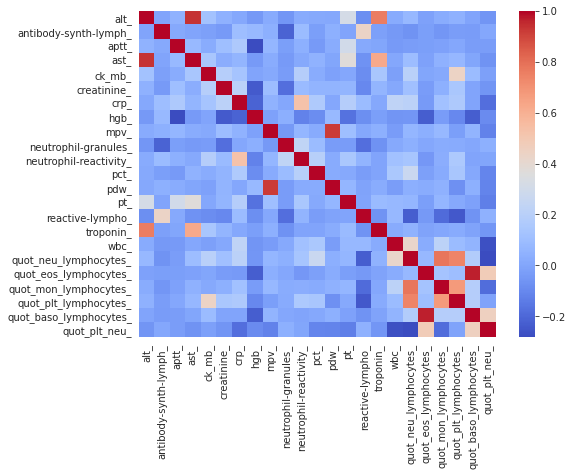

In [36]:
plt.figure(figsize=(8,6))
sns.heatmap(data=data.corr(), cmap='coolwarm')
plt.show()

Next target variable has to be replaced by numeric values to calculate correlation of features to target.

In [37]:
data_mod = data.copy()
data_mod[target] = data_mod[target].map(target_mapping)
data_mod[target] = data_mod[target].astype('float')
data_mod.corr()[target].sort_values()

quot_neu_lymphocytes_    -0.280672
wbc_                     -0.252697
quot_mon_lymphocytes_    -0.197556
pct_                     -0.187735
pt_                      -0.167718
quot_plt_lymphocytes_    -0.142922
neutrophil-granules_     -0.132211
crp_                     -0.129023
ast_                     -0.098254
alt_                     -0.093577
quot_baso_lymphocytes_   -0.091726
neutrophil-reactivity_   -0.062803
creatinine_              -0.062582
ck_mb_                   -0.057095
quot_eos_lymphocytes_    -0.048955
troponin_                -0.048017
aptt_                    -0.003143
pdw_                      0.049451
mpv_                      0.058571
hgb_                      0.070693
reactive-lympho_          0.082932
antibody-synth-lymph_     0.274321
quot_plt_neu_             0.292911
group                     1.000000
Name: group, dtype: float64

### Machine Learning

The pipeline for the ML-workflow looks as following:

In [38]:
pipe = joblib.load(f'pipe.joblib')

In [39]:
params = joblib.load(f'params.joblib')
print(pformat(params))

([{'prep__num_pipeline__imputer__n_neighbors': [1, 3, 5]}],
 [{'estimator': [LogisticRegression()],
   'estimator__C': [1],
   'estimator__penalty': ['l2']},
  {'estimator': [KNeighborsClassifier()], 'estimator__n_neighbors': [3]}])


Best hyperparameters as well as the performance statistics have been evaluated in section above: These are:

In [40]:
results = joblib.load(f"best_model.joblib")
keys = list(results.keys())
best_algorithm_name = keys[0]
print(f"Best algorithm: {best_algorithm_name}\n")
print(f"Best parameters: {results.get(keys[0])}\n")
print(f"statistics: {results.get(keys[1])}")

Best algorithm: LogisticRegression

Best parameters: {'estimator__C': 1, 'estimator__penalty': 'l2', 'prep__num_pipeline__imputer__n_neighbors': 3}

statistics:       mean_cv_accuracy  mean_train_accuracy  test_accuracy
mean          0.739660             0.763921       0.817829
std           0.042007             0.015108       0.060296


The model will be build from pipeline by replacing the dummy estimator by the best estimator and update the hyperparameters in the pipe. After this the pipe can be fitted on overall data!

In [41]:
X = data.drop([target], axis=1)
y = data[target]
y = y.map(target_mapping)  # for precision_scorer labels have to be binary with 0,1

In [42]:
updated_params = results.get(keys[0])
updated_params = {key:[value] for key,value in updated_params.items()}  # values have to be defined as list
updated_pipe = pipe
updated_pipe.steps.pop(-1)
updated_pipe.steps.append(('estimator', eval(f"{keys[0]}()")))  # adding () behind best model name and evaluate -> function

In [43]:
kfold = KFold(n_splits=5, shuffle=True)
model = GridSearchCV(estimator=updated_pipe ,param_grid=updated_params, cv=kfold ,n_jobs=-1,
                     return_train_score=True, scoring='accuracy', refit=True)
model.fit(X, y)
display(HTML(estimator_html_repr(model.best_estimator_)))

In [44]:
model.cv_results_

{'mean_fit_time': array([0.07731118]),
 'std_fit_time': array([0.02360386]),
 'mean_score_time': array([0.03645034]),
 'std_score_time': array([0.01827314]),
 'param_estimator__C': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_estimator__penalty': masked_array(data=['l2'],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_prep__num_pipeline__imputer__n_neighbors': masked_array(data=[3],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__C': 1,
   'estimator__penalty': 'l2',
   'prep__num_pipeline__imputer__n_neighbors': 3}],
 'split0_test_score': array([0.76699029]),
 'split1_test_score': array([0.69902913]),
 'split2_test_score': array([0.7961165]),
 'split3_test_score': array([0.76699029]),
 'split4_test_score': array([0.74757282]),
 'mean_test_score': array([0.75533981]),
 'std_test_score': array([0.03214164]),
 'rank_test_score

In [45]:
md('Best model cross-validated score is <b>{}</b>'.format(model.best_score_))

Best model cross-validated score is <b>0.7553398058252427</b>

### Predictions

The performance in prediction (example) can be slightly optimistic because the model was refit on all data (no train-, test). But in statistics above the 'true' (estimated) statistic values are shown.

In [46]:
y_pred = model.predict(X)

In [47]:
model.predict(X)[0:10]

array([0, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [48]:
try:
    model.predict_proba(X)[0:10]
except:
    pass

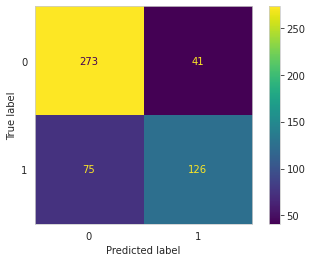

In [49]:
plt.Figure(figsize=(10,6))
plot_confusion_matrix(estimator=model, X=X, y_true=y)
plt.grid()
plt.savefig(f'confusion_matrix.png')

In [50]:
correct_classified = sum(model.predict(X) == y)
all_classified = len(y)
missclassified = all_classified - correct_classified
md('There are <b>{}</b> missclassifications on a total of <b>{}</b> observations'.format(missclassified, all_classified))

There are <b>116</b> missclassifications on a total of <b>515</b> observations

In [51]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       314
           1       0.75      0.63      0.68       201

    accuracy                           0.77       515
   macro avg       0.77      0.75      0.75       515
weighted avg       0.77      0.77      0.77       515



Confusion matrix as well as the classification report showing a well distributed picture. Precision, recall and f1-score are very close, so the model seems to work quit accurate!

### Feature Importance

This section tries to highlight the most important features in the dataset. Two approaches are chosen:
1. <b>regression coefficients</b> (only possible in regression models as LogisticRegression)
2. Feature importance with <b>SequentialFeatureSelection</b>

In [52]:
position_estimator = [idx for idx, i in enumerate(list(model.best_estimator_.named_steps)) if i == 'estimator'][0]
best_estimator = model.best_estimator_.steps.pop(position_estimator)[1]
preprocessed_x = model.best_estimator_.fit_transform(X)

In [53]:
if isinstance(preprocessed_x, pd.DataFrame):
    cols = preprocessed_x.columns
else:
    cols = X.columns

antibody-synth-lymph_     2.891147
quot_plt_neu_             2.574198
mpv_                      0.915362
aptt_                     0.590120
crp_                      0.437420
hgb_                      0.390099
neutrophil-reactivity_    0.343393
quot_plt_lymphocytes_     0.179302
pdw_                      0.056308
troponin_                 0.053534
alt_                     -0.039857
creatinine_              -0.163339
ast_                     -0.484916
quot_eos_lymphocytes_    -0.546001
reactive-lympho_         -0.571514
ck_mb_                   -0.754988
quot_baso_lymphocytes_   -0.948198
quot_mon_lymphocytes_    -1.328308
neutrophil-granules_     -1.343130
pct_                     -1.496318
pt_                      -1.530447
quot_neu_lymphocytes_    -1.826980
wbc_                     -2.147441
dtype: float64


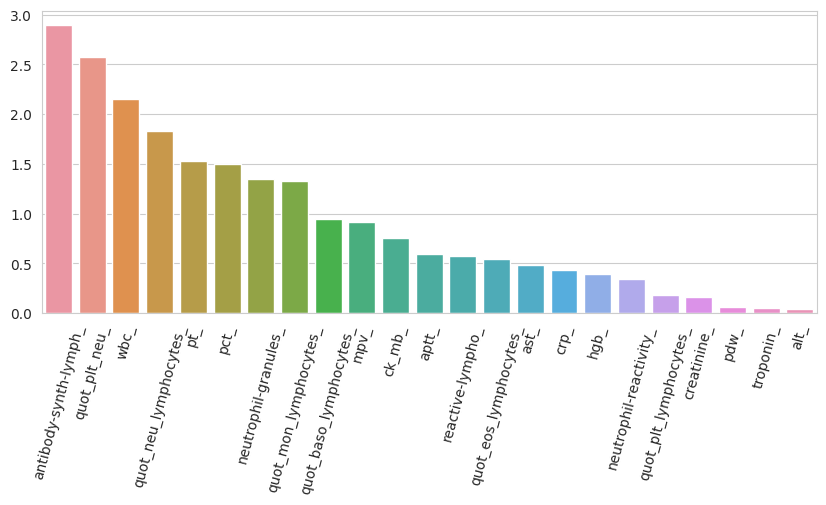

In [54]:
if best_algorithm_name == 'LogisticRegression':
    coefs = pd.Series(index=cols, data=best_estimator.coef_[0])
    coefs = coefs.sort_values(ascending=False)
    coefs_abs = abs(coefs).sort_values(ascending=False)
    print(coefs)

    # build plot
    plt.figure(figsize=(10,4), dpi=100)
    ax = sns.barplot(x=coefs_abs.index, y=coefs_abs.values)
    for item in ax.get_xticklabels():
        item.set_rotation(75)
    fig = ax.get_figure()
    fig.savefig(f'feature_importance.png')

    md("The most important features seems to be <b>{}</b>".format(coefs[0:7].index.to_list()))

A second approach for the feature importance is the sequential feature selection (SFS).

SFS does not work with a pipeline object, therefore the estimator will be removed, data will be preprocessed with pipe without estimator and this estimator is given to SFS.

In [55]:
if re_calculate is False and os.path.isfile('feature_importance.joblib'):
    feature_importance = joblib.load('feature_importance.joblib')
    sfs = joblib.load('sfs.joblib')
else:
    sfs = SFS(best_estimator,
               k_features=no_features,
               forward=True,
               scoring='accuracy',
               cv=5,
               n_jobs=-1)
    sfs = sfs.fit(preprocessed_x, y, custom_feature_names=cols.to_list())
    feature_importance = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    joblib.dump(feature_importance, 'feature_importance.joblib')
    joblib.dump(sfs, 'sfs.joblib')

feature_importance

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(16,)","[0.6796116504854369, 0.6893203883495146, 0.689...",0.700971,"(wbc_,)",0.026647,0.020732,0.010366
2,"(16, 19)","[0.7378640776699029, 0.7087378640776699, 0.708...",0.730097,"(wbc_, quot_mon_lymphocytes_)",0.038984,0.030331,0.015166
3,"(1, 16, 19)","[0.7281553398058253, 0.7087378640776699, 0.747...",0.753398,"(antibody-synth-lymph_, wbc_, quot_mon_lymphoc...",0.050903,0.039604,0.019802
4,"(1, 16, 19, 22)","[0.7669902912621359, 0.7572815533980582, 0.737...",0.763107,"(antibody-synth-lymph_, wbc_, quot_mon_lymphoc...",0.020275,0.015775,0.007887
5,"(1, 8, 16, 19, 22)","[0.7766990291262136, 0.7669902912621359, 0.747...",0.768932,"(antibody-synth-lymph_, mpv_, wbc_, quot_mon_l...",0.034761,0.027045,0.013523
6,"(0, 1, 8, 16, 19, 22)","[0.7766990291262136, 0.7669902912621359, 0.747...",0.770874,"(alt_, antibody-synth-lymph_, mpv_, wbc_, quot...",0.032155,0.025018,0.012509
7,"(0, 1, 8, 15, 16, 19, 22)","[0.7766990291262136, 0.7669902912621359, 0.747...",0.770874,"(alt_, antibody-synth-lymph_, mpv_, troponin_,...",0.032155,0.025018,0.012509
8,"(0, 1, 8, 15, 16, 18, 19, 22)","[0.7766990291262136, 0.7669902912621359, 0.747...",0.770874,"(alt_, antibody-synth-lymph_, mpv_, troponin_,...",0.032155,0.025018,0.012509
9,"(0, 1, 8, 10, 15, 16, 18, 19, 22)","[0.7766990291262136, 0.7669902912621359, 0.747...",0.772816,"(alt_, antibody-synth-lymph_, mpv_, neutrophil...",0.030156,0.023462,0.011731
10,"(0, 1, 8, 10, 15, 16, 18, 19, 21, 22)","[0.7766990291262136, 0.7766990291262136, 0.737...",0.770874,"(alt_, antibody-synth-lymph_, mpv_, neutrophil...",0.03494,0.027184,0.013592


In [56]:
def transform_feature_importance_to_list(feature_importance):
        feature_list = []
        for idx, item in enumerate(feature_importance['feature_names']):
            if idx == 0:
                feature_list.append(item[0])
            else:
                diff = [i for i in item if i not in feature_list]
                feature_list.append(diff[0])
        return feature_list
feature_importance_list = transform_feature_importance_to_list(feature_importance)
md("The most important features seems to be <br><br> <b>{}</b> <br><br> -> ordered by importance from important to less important!".format(feature_importance_list))

The most important features seems to be <br><br> <b>['wbc_', 'quot_mon_lymphocytes_', 'antibody-synth-lymph_', 'quot_plt_neu_', 'mpv_', 'alt_', 'troponin_', 'quot_eos_lymphocytes_', 'neutrophil-reactivity_', 'quot_baso_lymphocytes_', 'ck_mb_', 'neutrophil-granules_', 'crp_', 'reactive-lympho_', 'pct_']</b> <br><br> -> ordered by importance from important to less important!

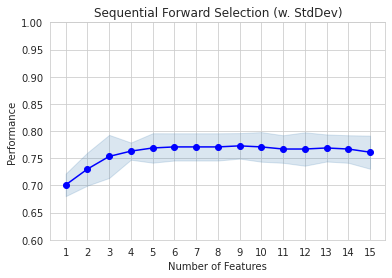

In [57]:
plt.Figure(figsize=(10,6))
plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.6,1.0])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.savefig('sfs.png')

# Evaluate all  (best) models (Feature Importance)

In [58]:
no_features = 10

In [59]:
if study_type == 'long':
    wf = f"{working_file}"
else:
    wf = f"{working_file}_adjusted"
    
evaluation = ModelEvaluation(working_file = f"{wf}.pkl",
                             target=target,
                             simulation_file='train_test_split_simulation.csv',
                             pipe='pipe.joblib')

In [60]:
if re_calculate is False and os.path.isfile('overview_models.joblib'):
    overview_models = joblib.load('overview_models.joblib')
else:
    overview_models = evaluation.analyze_models(test_size=test_size, no_features=no_features)
    joblib.dump(overview_models, 'overview_models.joblib')

IndexError: index 0 is out of bounds for axis 0 with size 0

In [61]:
pprint(overview_models)

NameError: name 'overview_models' is not defined

In [62]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [43]:
# store this notebook as html in specific folder
os.system(f'jupyter nbconvert --to html final_evaluation.ipynb')

0